In [1]:
# Per recomendation to read and try things from this paper https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# Here is my attempt to implement an Energy Minimization Network [from part 5. Extensions and Future Work]
# Authors postulate the original neural language model extend last layer into full vocab (which can be very large)
# and don't utilize semantic or syntactic sumilarities between output words.
# In essence this energy function we want to learn utilizing same idea of emeding space but extends to use target word/character
# to produce energy score of the sentence/sequence.
# Example with context=3
# eg. E(wt-2, wt-1, wt) = v.tanh(d + Hx) + sum(bwt, bwt-1, bwt-2) = formula of energy score
# x = (C(wt), C(wt-1), C(wt-2)); note: target word/char included
# E - energy score of the sequence, w - word/character, x - concatenation of embedings, C - lookup matrix,
# tanh(d + Hx) - neural net hidden layer, v - projection vector to get score via dot product,
# b - biases for all words/characters.
# E(wt-2, wt-1, wt)  is interpreted as unnormalized log-probability for the joint occurence of (wt-2, wt-1, wt),
# To obtain a conditional prob P(wt|sequence before wt) we need to normalize over all possible values of wt (our case 27 possible chars)
# P(wt|sequence before wt) = exp(-E(wt-2, wt-1, wt)) / sum(exp(-E(wt-2, wt-1, i)))
# and finally we can learn set of weights with gradient descent minimizing -log(P(wt|sequence before wt))

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:3]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .


In [7]:
# Lets work through single example
x, y = X[2], Y[2]
x.shape, y.shape

(torch.Size([3]), torch.Size([]))

In [8]:
C = torch.randn((27, 2)) * (1/27)**0.5

In [9]:
# for one example we want to compute energy score for all possible target characters
# this repeats the embedings of context and concatenates all possible target character embedings to it
embs = torch.concat((C[x].view(-1, 6).repeat(27, 1), C), 1)
embs.shape

torch.Size([27, 8])

In [10]:
H = torch.randn((8, 100)) * (1/8)**0.5 # target is in the sequence
d = torch.randn(100) * (1/100)**0.5
v = torch.randn(100) * (1/100)**0.5
b = torch.randn(27) * (1/27)**0.5

In [11]:
# pass through hidden layer
h = torch.tanh(embs @ H + d)

In [12]:
h.shape

torch.Size([27, 100])

In [13]:
# this computes energy for our example context + all possible (27) following characters
e = h @ v + b # we add corresponding biases 0 -> 0, 1 -> 1 and so on

In [14]:
torch.softmax(e, 0).sum() # if we softmax it sums to 1., as expected

tensor(1.0000)

In [15]:
# we can check loss X-entropy = logsoftmax + nll
F.cross_entropy(e, y)

tensor(2.9603)

In [16]:
-torch.log(torch.tensor(1/27))

tensor(3.2958)

In [17]:
# We want to work with batches eventually
X.shape, Y.shape

(torch.Size([16, 3]), torch.Size([16]))

In [18]:
emb = C[X].view(-1, 6)

In [19]:
emb_exp = emb.unsqueeze(1).repeat(1, C.shape[0], 1) # Shape [16, 27, 6]

In [20]:
C_exp = C.unsqueeze(0).expand(X.shape[0], -1, -1)  # Shape [16, 27, 2]

In [21]:
emb_all = torch.cat((emb_exp, C_exp), -1) # Shape [16, 27, 8]

In [22]:
# pass through hidden layer
h = torch.tanh(emb_all @ H + d) # Shape [16, 27, 100]

In [23]:
# this computes energy for our example context + all possible (27) following characters
e = h @ v + b # we add corresponding biases 0 -> 0, 1 -> 1 and so on, Shape [16, 27]

In [24]:
torch.softmax(e, 1)[0].sum() # if we softmax it sums to 1., as expected

tensor(1.0000)

In [25]:
# we can check loss X-entropy = logsoftmax + nll
F.cross_entropy(e, Y)

tensor(3.2547)

In [26]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
r = random.Random(2147483647)
r.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182546, 3]) torch.Size([182546])
torch.Size([22840, 3]) torch.Size([22840])
torch.Size([22760, 3]) torch.Size([22760])


In [27]:
words[:n1][:5], words[n1:n2][:5], words[n2:][:5]

(['khole', 'harbour', 'devon', 'baine', 'erisha'],
 ['shterna', 'tyanna', 'sarra', 'malachy', 'zenaya'],
 ['phoenyx', 'christionna', 'bastien', 'niloufar', 'masa'])

In [28]:
# ------------ now made respectable :) ---------------

In [65]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182546, 3]), torch.Size([182546]))

In [66]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
emb_size = 10
hid_size = 512
C = torch.randn((27, emb_size), generator=g) * (1/27)**0.5
H = torch.randn((emb_size * (block_size + 1), hid_size), generator=g) * (1/(emb_size * (block_size + 1)))**0.5
d = torch.randn(hid_size, generator=g) * (1/hid_size)**0.5
v = torch.randn(hid_size, generator=g) * (1/hid_size)**0.5
b = torch.randn(27, generator=g) * (1/27)**0.5
parameters = [C, H, d, v, b]

In [67]:
sum(p.nelement() for p in parameters) # number of parameters in total

21801

In [68]:
for p in parameters:
  p.requires_grad = True

In [50]:
lre = torch.linspace(-6, 0, 1000)
lrs = 10**lre

In [51]:
# find learning rate
lri = []
lossi = []
bs = 256
C_exp = C.unsqueeze(0).expand(bs, -1, -1)  # Shape [bs, 27, emb_size]

for i in range(1000):
  
  # forward pass
  # minibatch construct (use same batch sequencies across experiments)
  ix = torch.randint(0, Xtr.shape[0], (bs,), generator=g)
  
  # forward pass
  emb = C[Xtr[ix]].view(bs, -1) # Shape [bs, block size *embeeding size]
  emb_exp = emb.unsqueeze(1).repeat(1, C.shape[0], 1) # Shape [bs, 27, block_size * emb_size]
  emb_all = torch.cat((emb_exp, C_exp), -1) # Shape [bs, 27, (block_size + 1)*emb_size]
  
  h = torch.tanh(emb_all @ H + d) # Shape [bs, 27, hid_dim]
  logits = h @ v + b # Shape [bs, 27]
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

#print(loss.item())

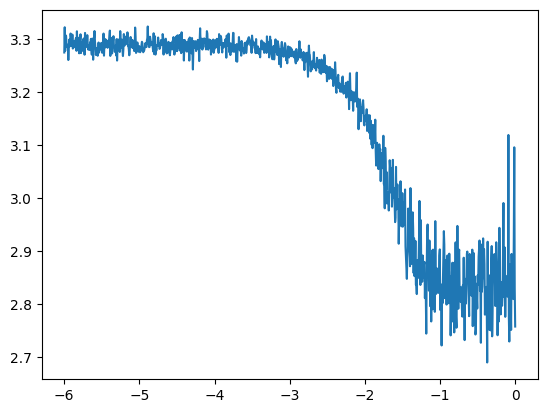

In [52]:
plt.plot(lri, lossi)

In [69]:
lossi = []
reg_strength = 1.0
bs = 128

C_exp = C.unsqueeze(0).expand(bs, -1, -1)  # Shape [bs, 27, emb_size]

for i in range(200000):
  
  # minibatch construct (use same batch sequencies across experiments)
  ix = torch.randint(0, Xtr.shape[0], (bs,), generator=g)
  
  # forward pass
  emb = C[Xtr[ix]].view(bs, -1) # Shape [bs, block size *embeeding size]
  emb_exp = emb.unsqueeze(1).repeat(1, C.shape[0], 1) # Shape [bs, 27, block_size * emb_size]
  emb_all = torch.cat((emb_exp, C_exp), -1) # Shape [bs, 27, (block_size + 1)*emb_size]
  
  h = torch.tanh(emb_all @ H + d) # Shape [bs, 27, hid_dim]
  logits = h @ v + b # Shape [bs, 27]
  reg_loss = 0.5 * reg_strength * sum([(p**2).mean() for p in parameters]) # const 0.5 for better gradient = reg_strength * p
  loss = F.cross_entropy(logits, Ytr[ix]) + reg_loss
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.2 if i < 100000 else 0.02
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  lossi.append(loss.log10().item())

#print(loss.item())

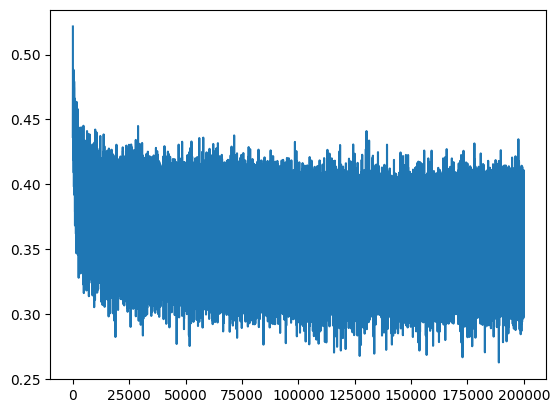

In [70]:
plt.plot(lossi)

In [59]:
with torch.no_grad():
  C_exp = C.unsqueeze(0).expand(Xtr.shape[0], -1, -1)  # Shape [bs, 27, emb_size]
  emb = C[Xtr].view(Xtr.shape[0], -1) # Shape [bs, block size *embeeding size]
  emb_exp = emb.unsqueeze(1).repeat(1, C.shape[0], 1) # Shape [bs, 27, block_size * emb_size]
  emb_all = torch.cat((emb_exp, C_exp), -1) # Shape [bs, 27, (block_size + 1)*emb_size]
  
  h = torch.tanh(emb_all @ H + d) # Shape [bs, 27, hid_dim]
  logits = h @ v + b # Shape [bs, 27]
  loss = F.cross_entropy(logits, Ytr)
  print(loss)

tensor(2.1089)


In [60]:
with torch.no_grad():
  C_exp = C.unsqueeze(0).expand(Xdev.shape[0], -1, -1)  # Shape [bs, 27, emb_size]
  emb = C[Xdev].view(Xdev.shape[0], -1) # Shape [bs, block size *embeeding size]
  emb_exp = emb.unsqueeze(1).repeat(1, C.shape[0], 1) # Shape [bs, 27, block_size * emb_size]
  emb_all = torch.cat((emb_exp, C_exp), -1) # Shape [bs, 27, (block_size + 1)*emb_size]
  
  h = torch.tanh(emb_all @ H + d) # Shape [bs, 27, hid_dim]
  logits = h @ v + b # Shape [bs, 27]
  loss = F.cross_entropy(logits, Ydev)
  print(loss)

tensor(2.1479)


In [61]:
with torch.no_grad():
  C_exp = C.unsqueeze(0).expand(Xte.shape[0], -1, -1)  # Shape [bs, 27, emb_size]
  emb = C[Xte].view(Xte.shape[0], -1) # Shape [bs, block size *embeeding size]
  emb_exp = emb.unsqueeze(1).repeat(1, C.shape[0], 1) # Shape [bs, 27, block_size * emb_size]
  emb_all = torch.cat((emb_exp, C_exp), -1) # Shape [bs, 27, (block_size + 1)*emb_size]
  
  h = torch.tanh(emb_all @ H + d) # Shape [bs, 27, hid_dim]
  logits = h @ v + b # Shape [bs, 27]
  loss = F.cross_entropy(logits, Yte)
  print(loss)

tensor(2.1380)


In [71]:
# bias b corresponds to unconditional probabilities of characters also makes sense in this regard
b

tensor([-0.0044,  0.0016,  0.0021, -0.0012,  0.0011,  0.0016,  0.0029, -0.0005,
        -0.0005, -0.0060, -0.0036,  0.0013,  0.0002,  0.0013,  0.0018,  0.0023,
        -0.0063, -0.0009, -0.0032,  0.0065,  0.0048,  0.0025, -0.0057,  0.0042,
        -0.0086,  0.0079, -0.0011], requires_grad=True)

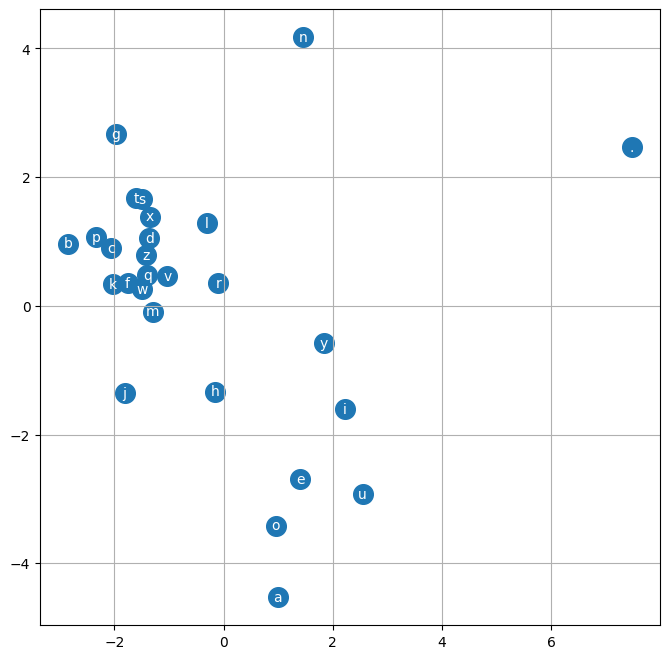

In [215]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
# using energy based network we learned reasonable 2d embedings.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [72]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [73]:


# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    # sample first character [like y for our energy minimization network]
    yix = torch.randint(low=1, high=26, size=(1,), generator=g).item()
    out.append(yix)
    context.append(yix)
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1,-1) @ H + d) # Shape [bs, 27, hid_dim]
      logits = h @ v + b # Shape [bs, 27]
      probs = F.softmax(logits, dim=0)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

guwjdvdipkcqaz.
e.
tfqywocnzqfjiirltozcogsjgwzvudlhnpauyjbilevhajkdbduinrwibtlzsnjyievyvaftbzffvmumthyfodtumjrpfytszwjhrjagq.
aoreaysezocfkyjjabdywejfmoifmwyfinwagaasnhsvfihofszxhddgosfmptpagicz.
ujpiufmthdt.
rkrrsru.
tyumuyfy.
tjekujcbkhvupwyhvpvhvccragr.
hdkhwfdztta.
yplyisbxlyhuuiqzavmpocbzthqmimvyqwat.
l.
endxjxfpvslqtikyzsaloevgvvnundewkfmbjzqegruxiteaxchwtmurzsodridcdznojvaliypvrghvxtezrwguciqqvywhqelvsviosvhibdhnceukgmtmwboscnbzoiwupnwnpipixtewbgsgyewfdacbfcxrvjypkmsbranmjrdsydotafvkdkbdepihzpwzsqdab.
vfuolwbasrtugttbiqbujfdtskceqjtcdlcndfujqllsppgkltalmlokdmsl.
dddmxjv.
rfsgxmw.
ydihkvngtojvrdsyqivcob.
lziengogtjvnvqgfjtkqufrxfjlwglykiiluohgnoiuwzylq.
lsgircvmhtipagkxwvjypnsriadmfujnlkcicvatjvryzeljxkbrlrjsp.
uuybxzhwuejbiotzqpxrkbhhhgsivfjblaklxoivwqjpdkucftazqgwslvrvqcqmbadayrgufbalqdoumwytowbzqzrvbddvlhqn.
kvhztsmltmpcxnikfn.
